In [1]:
import shap

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation, Dropout, AveragePooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Embedding,GRU, LSTM,Bidirectional,TimeDistributed,AveragePooling1D,GlobalMaxPool1D,Reshape,Input,Concatenate,concatenate,Attention,Permute, Lambda,RepeatVector,Add, Conv3D, MaxPool3D
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

import pandas as pd
import numpy as np

import os
import random

import matplotlib.pyplot as plt
import seaborn as sb

import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from ast import literal_eval

import cv2

In [2]:
#UNLIST GPU OPTION FOR TENSORFLOW 2.1. GPU RUNS OUT OF MEMORY WITH THIS NN MODEL 
# tf.config.set_visible_devices([], 'GPU')

IMG_SIZE = 150
CHANNELS = 3       # 1 for cv2.IMREAD_GRAYSCALE, 3 for cv2.IMREAD_COLOR

train = []
training_labels = []

DATADIR = 'D:\\111880_269359_bundle_archive' # IDENTIFIER

CATEGORIES = ['buildings','forest','glacier','mountain','sea', 'street']

In [3]:
def create_training_data():
    for category in CATEGORIES:               
        path = os.path.join(DATADIR + '\\seg_train\\seg_train', category) # path to each label's repository
        class_num = CATEGORIES.index(category)
        counter = 0
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR) #  IMREAD_GRAYSCALE
            if type(img_array) == np.ndarray:
                height, weight, channels = img_array.shape   # ,channels   for color

                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train.append( np.float32(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB) / 255 ))
                training_labels.append(class_num)

                    
create_training_data()

100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:05<00:00, 404.81it/s]


In [4]:
test = []      
testing_labels = []

def create_testing_data():
    for category in CATEGORIES:               
        path = os.path.join(DATADIR + '\\seg_test\\seg_test', category) # path to each label's repository
        class_num = CATEGORIES.index(category)
        counter = 0
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR) #  IMREAD_GRAYSCALE
            if type(img_array) == np.ndarray:
                height, weight, channels = img_array.shape   # ,channels   for color

                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test.append( np.float32(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB) / 255) )
                testing_labels.append(class_num)
                
create_testing_data()

100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 485.82it/s]


In [5]:
train = np.array(train, dtype = 'float32')
test = np.array(test, dtype = 'float32')

labeltrainhot = to_categorical(np.array(training_labels))
labeltesthot = to_categorical(np.array(testing_labels))


seed = 1000
np.random.seed(seed)
np.random.shuffle(train)

np.random.seed(seed)
np.random.shuffle(labeltrainhot)

np.random.seed(seed)  
np.random.shuffle(test)

np.random.seed(seed)  
np.random.shuffle(labeltesthot)

In [6]:
def Create_Model(length1):
    
    # IGNORE THE CHANNELS FOR CONV AND POOL ,3
    
	# query
    inputs1 = Input(shape=(length1))
    
    conv1 = Conv2D(filters=16, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(inputs1)
    pool2 = MaxPool2D(pool_size=(2,2))(conv1) # , strides = 2
    
    conv3 = Conv2D(filters=32, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool2)
    pool4 = MaxPool2D(pool_size=(2,2))(conv3) # , strides = 2
    
    #conv5 = Conv2D(filters=256, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool4)
    conv6 = Conv2D(filters=64, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(conv3)
    pool7 = MaxPool2D(pool_size=(2,2))(conv6) # , strides = 2
    
    #conv8 = Conv2D(filters=512, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool7)
    conv9 = Conv2D(filters=128, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool7)
    pool10 = MaxPool2D(pool_size=(2,2))(conv9) # , strides = 2
    
    #conv11 = Conv2D(filters=512, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool10)
    conv12 = Conv2D(filters=128, kernel_size=(3,3), strides = 1, activation='relu', padding = 'same')(pool10)
    pool13 = MaxPool2D(pool_size=(2,2))(conv12) # , strides = 2
    
    flat1 = Flatten()(pool13)
    dense1 = Dense(4096, activation = 'relu', kernel_regularizer = l2(0.05))(flat1)
    drop1 = Dropout(0.01)(dense1)
    dense2 = Dense(4096, activation = 'relu', kernel_regularizer = l2(0.05))(drop1)
    drop2 = Dropout(0.01)(dense2)
    dense3 = Dense(1000, activation = 'relu', kernel_regularizer = l2(0.05))(drop2)    
    #drop3 = Dropout(0.05)
    
    outputs = Dense(len(set(CATEGORIES)), activation='softmax')(dense3)                                   # number of classes   4  activation='softmax'
    model = Model(inputs=inputs1, outputs=outputs)

    model.compile(Adam(lr = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])   #  categorical_crossentropy   loss = 'mean_absolute_error'    metrics = [MeanAbsoluteError()]  ??    metrics = [RootMeanSquaredError()]

    print(model.summary())
    plot_model(model, show_shapes=True, to_file='VGG_BASED_ARCHITECTURE.png')
    return model

model = Create_Model(train[0].shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856 

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train, labeltrainhot , epochs=32, validation_data=(test, labeltesthot), batch_size = 32)

Train on 14034 samples, validate on 3000 samples
Epoch 1/20
14034/14034 [==============================] - 21s 2ms/sample - loss: 11.1724 - accuracy: 0.4389 - val_loss: 1.2749 - val_accuracy: 0.5703
Epoch 2/20
14034/14034 [==============================] - 17s 1ms/sample - loss: 1.1770 - accuracy: 0.6020 - val_loss: 1.0620 - val_accuracy: 0.6737
Epoch 3/20
14034/14034 [==============================] - 17s 1ms/sample - loss: 0.9487 - accuracy: 0.6835 - val_loss: 0.9040 - val_accuracy: 0.7150
Epoch 4/20
14034/14034 [==============================] - 17s 1ms/sample - loss: 0.9058 - accuracy: 0.7159 - val_loss: 0.8986 - val_accuracy: 0.7310
Epoch 5/20
14034/14034 [==============================] - 17s 1ms/sample - loss: 0.8441 - accuracy: 0.7492 - val_loss: 0.8329 - val_accuracy: 0.7593
Epoch 6/20
14034/14034 [==============================] - 17s 1ms/sample - loss: 0.8341 - accuracy: 0.7704 - val_loss: 0.8585 - val_accuracy: 0.7650
Epoch 7/20
14034/14034 [==============================] 

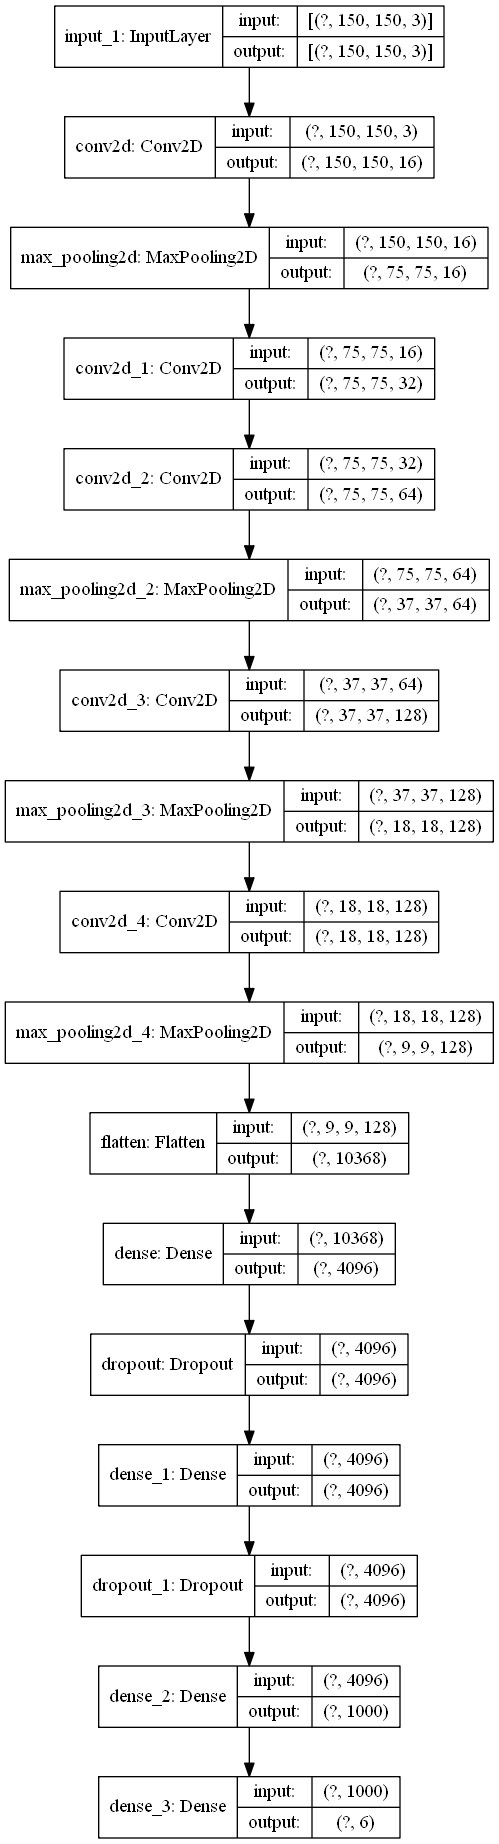

In [8]:
plot_model(model, show_shapes=True)

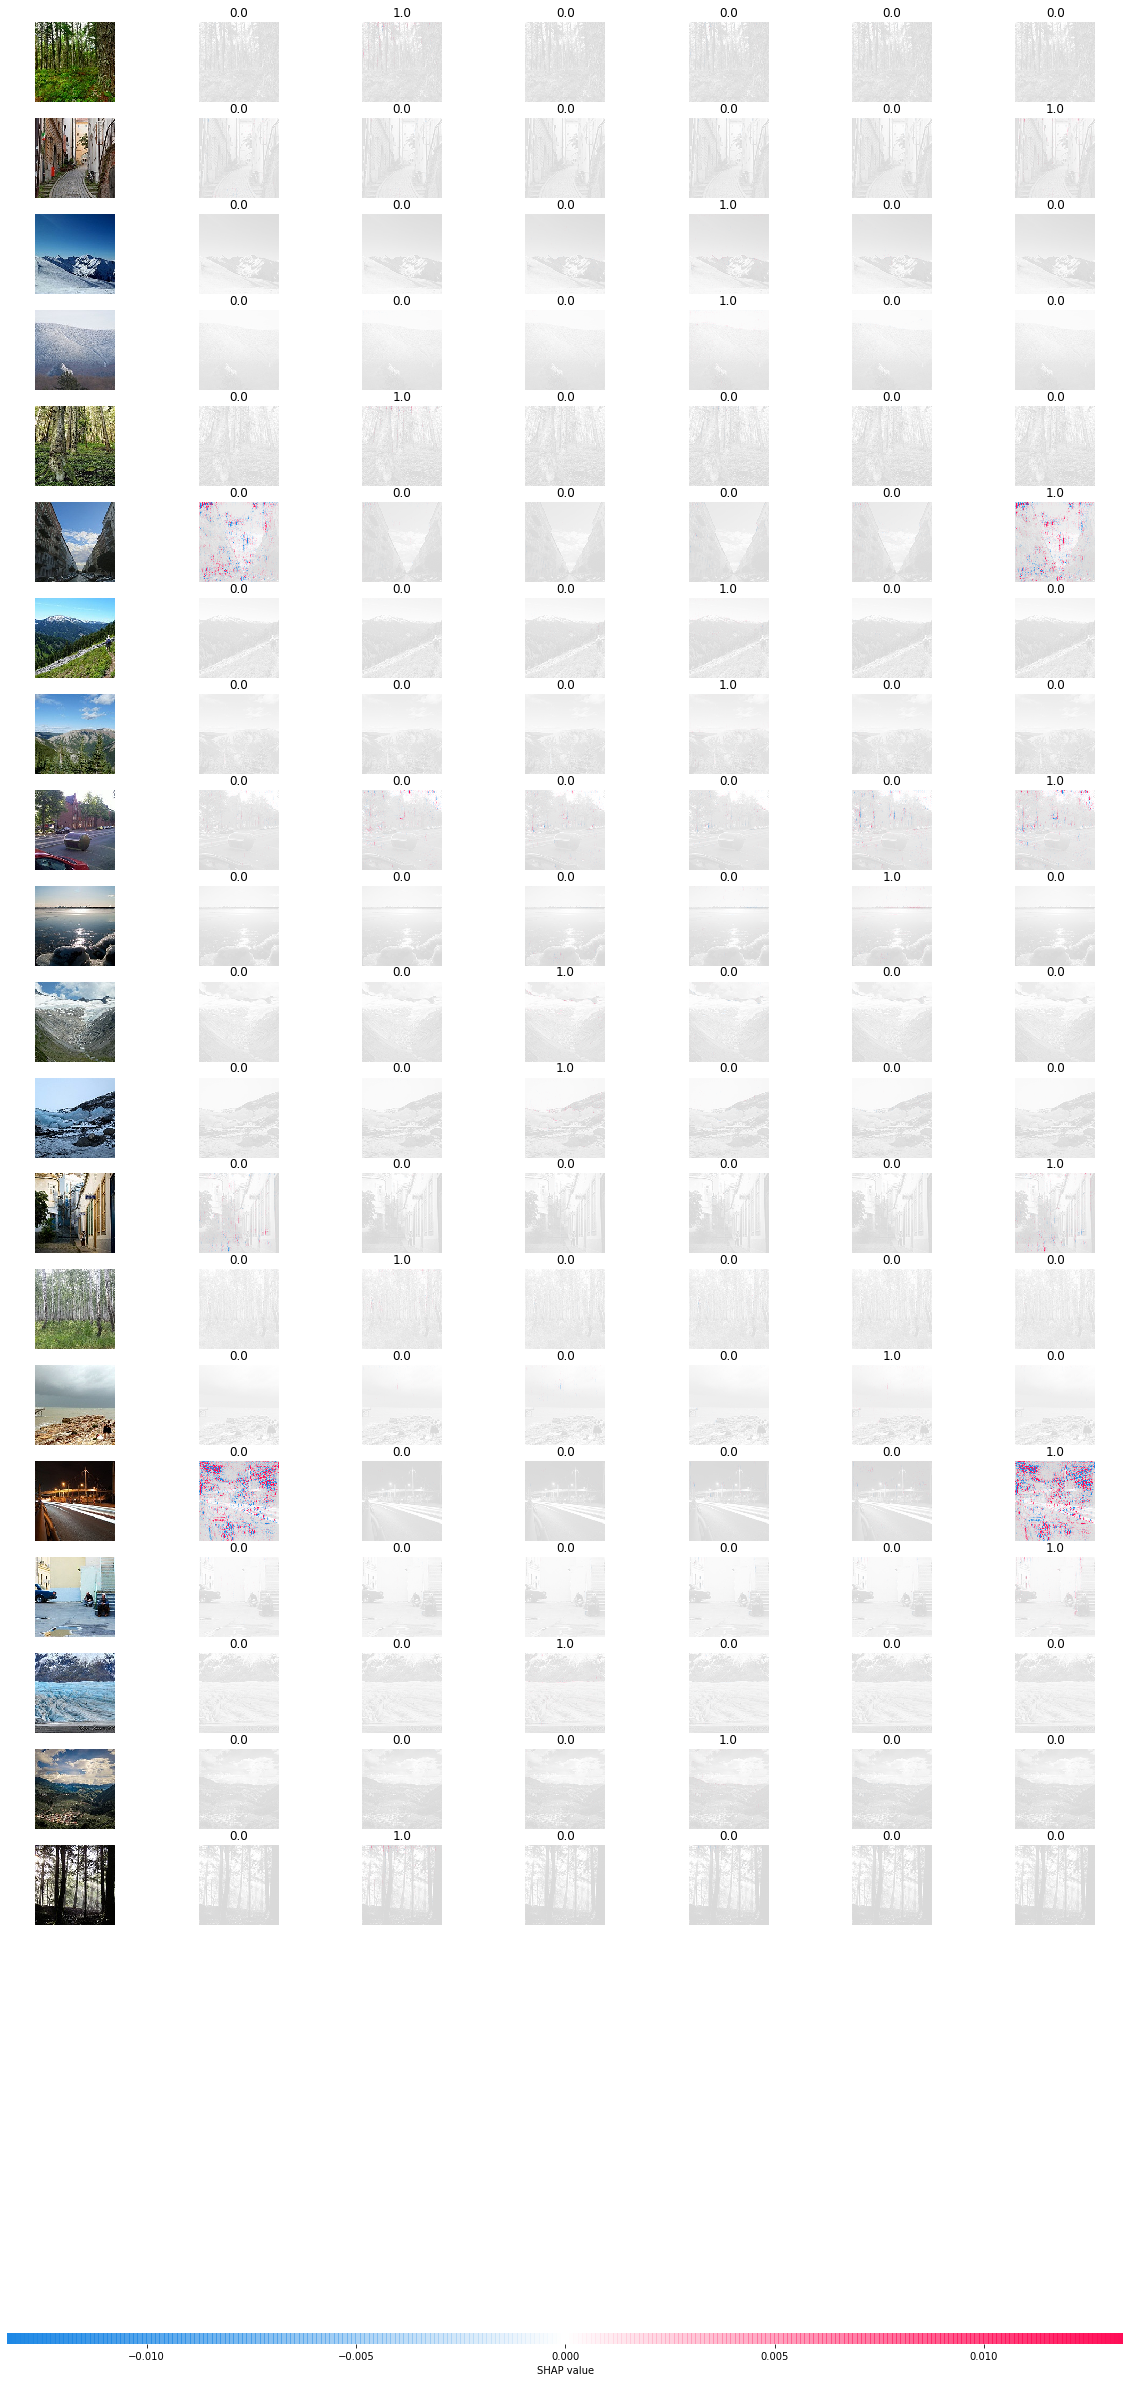

In [10]:
# with tf.device('/cpu:0'):
with tf.device('/cpu:0'):
    # explain predictions of the model on four images
    e = shap.DeepExplainer(model, train[0:100])

    # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
    shap_values = e.shap_values(test[20:40])

    # plot the feature attributions
    shap.image_plot(shap_values, test[20:40], labels = labeltesthot[20:40])   # THE DOCUMENTATION LIES WHEN IT SAYS IT WANTS A LIST FOR LABELS!!!